---
title: Prediction Uncertainty Quantification in AR models
---

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from scipy import stats

The following data is on personal consumption expenditures from FRED (https://fred.stlouisfed.org/series/PCEC). It measures the total amount of money that U.S. households spend on goods and services. This is a time-series record of that spending reported quarterly in billions of dollars (with seasonal adjustment). This measure is compiled by the Bureau of Economic Analysis (BEA) and is a key indicator used to track consumer demand and overall economic activity in the United States.

  observation_date     PCEC
0       1947-01-01  156.161
1       1947-04-01  160.031
2       1947-07-01  163.543
3       1947-10-01  167.672
4       1948-01-01  170.372


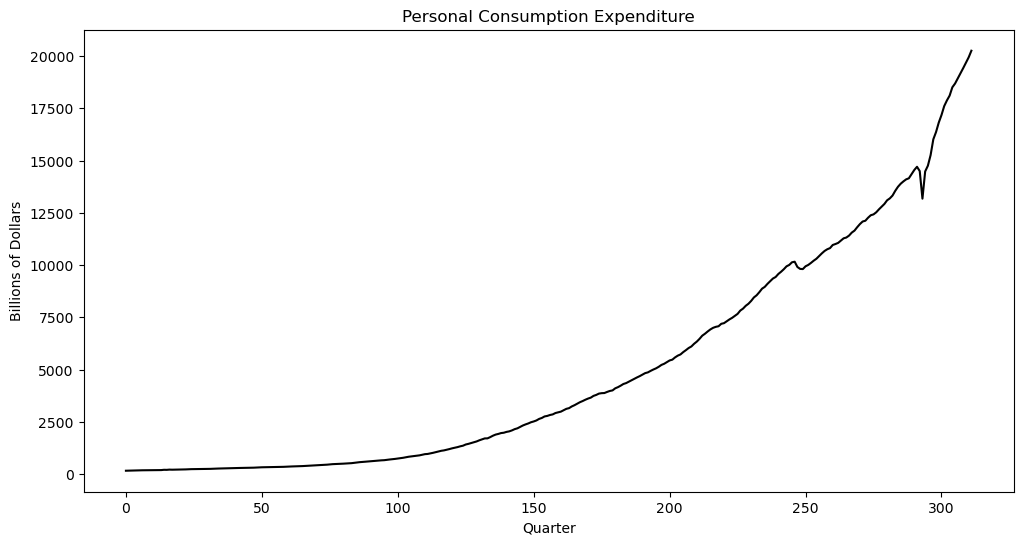

In [150]:
pcec = pd.read_csv("PCEC_03April2025.csv")
print(pcec.head())
y = pcec['PCEC']
plt.figure(figsize = (12, 6))
plt.plot(y, color = 'black')
plt.xlabel('Quarter')
plt.ylabel('Billions of Dollars')
plt.title('Personal Consumption Expenditure')
plt.show()

We will fit AR(p) models to this dataset, and use the fitted models to predict future values. Let us leave the last 12 observations (corresponding to three years) as test values, and the remaining data form the training data. We will fit AR(p) models to the training data, predict the test values and then compare the predictions with the actual test values. 

In [151]:
n = len(y)
tme = range(1, n+1)
n_test = 12
n_train = n - n_test
y_train = y[:n_train]
tme_train = tme[:n_train]
y_test = y[n_train:]
tme_test = tme[n_train:]

Below, we fit AR(p) to the training data. 

In [156]:
p = 1 #for selecting p, some heuristics can be used (one such method will be detailed in the lab tomorrow)
armod_sm = AutoReg(y_train, lags = p).fit()
print(armod_sm.summary())

                            AutoReg Model Results                             
Dep. Variable:                   PCEC   No. Observations:                  300
Model:                     AutoReg(1)   Log Likelihood               -1866.593
Method:               Conditional MLE   S.D. of innovations            124.443
Date:                Thu, 03 Apr 2025   AIC                           3739.187
Time:                        15:46:12   BIC                           3750.288
Sample:                             1   HQIC                          3743.630
                                  300                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.3717      9.975      0.940      0.347     -10.178      28.922
PCEC.L1        1.0106      0.002    638.038      0.000       1.008       1.014
                                    Roots           

Here is how the fitted model can be used to predict the test observations. 

In [157]:
k = n_test
fcast = armod_sm.get_prediction(start = n_train, end = n_train+k-1)
fcast_mean = fcast.predicted_mean #this gives the point predictions: the fitted model's best estimate (expected value) of the future values of the time series 

The method that the above function uses to calculate the predictions was detailed in class; and is captured in the code below. 

In [158]:
#Predictions
yhat = np.concatenate([y_train.astype(float), np.full(k, -9999)]) #extend data by k placeholder values
phi_vals = armod_sm.params
for i in range(1, k+1):
    ans = phi_vals.iloc[0]
    for j in range(1, p+1):
        ans += phi_vals.iloc[j] * yhat[n_train+i-j-1]
    yhat[n_train+i-1] = ans
predvalues = yhat[n_train:]

#Check that both predictions are identical:
print(np.column_stack([predvalues, fcast_mean]))

[[17004.24661408 17004.24661408]
 [17194.3607461  17194.3607461 ]
 [17386.49564942 17386.49564942]
 [17580.67280334 17580.67280334]
 [17776.91391546 17776.91391546]
 [17975.24092412 17975.24092412]
 [18175.67600083 18175.67600083]
 [18378.2415528  18378.2415528 ]
 [18582.96022537 18582.96022537]
 [18789.85490462 18789.85490462]
 [18998.94871987 18998.94871987]
 [19210.26504629 19210.26504629]]


Below we plot the predictions along with the actual test observations. 

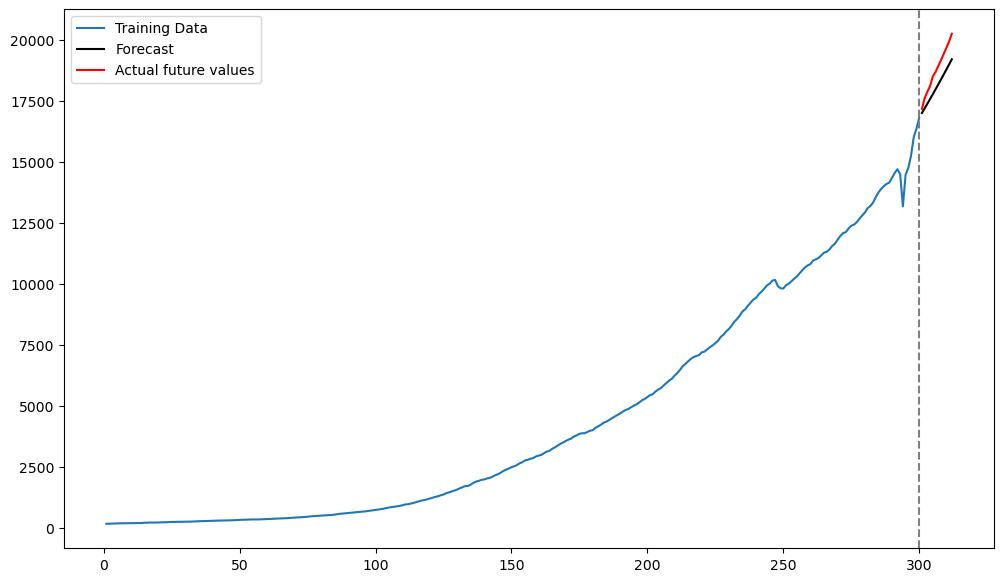

In [159]:
plt.figure(figsize = (12, 7))
plt.plot(tme_train, y_train, label = 'Training Data')
plt.plot(tme_test, fcast_mean, label = 'Forecast', color = 'black')
plt.plot(tme_test, y_test, color = 'red',  label = 'Actual future values')
plt.axvline(x=n_train, color='gray', linestyle='--')
plt.legend()
plt.show()

Next we discuss prediction uncertainty quantification. The prediction standard errors, and the associated uncertainty intervals, are calculated as follows. 

In [160]:
fcast_se = fcast.se_mean
alpha = 0.05
z_alpha_half = stats.norm.ppf(1 - alpha/2)
predlower = predvalues - z_alpha_half * fcast_se
predupper = predvalues + z_alpha_half * fcast_se
fcast_int = fcast.conf_int()
print(np.column_stack([predlower, predupper, fcast_int]))


[[16760.34256946 17248.15065871 16760.34256946 17248.15065871]
 [16847.5903057  17541.13118649 16847.5903057  17541.13118649]
 [16959.51925994 17813.47203889 16959.51925994 17813.47203889]
 [17084.99727308 18076.3483336  17084.99727308 18076.3483336 ]
 [17219.74763362 18334.08019731 17219.74763362 18334.08019731]
 [17361.59779426 18588.88405398 17361.59779426 18588.88405398]
 [17509.27171192 18842.08028975 17509.27171192 18842.08028975]
 [17661.94913809 19094.5339675  17661.94913809 19094.5339675 ]
 [17819.06940933 19346.85104141 17819.06940933 19346.85104141]
 [17980.23199936 19599.47780988 17980.23199936 19599.47780988]
 [18145.14124017 19852.75619956 18145.14124017 19852.75619956]
 [18313.57338418 20106.95670841 18313.57338418 20106.95670841]]


Below we plot the predictions along with uncertainty intervals.

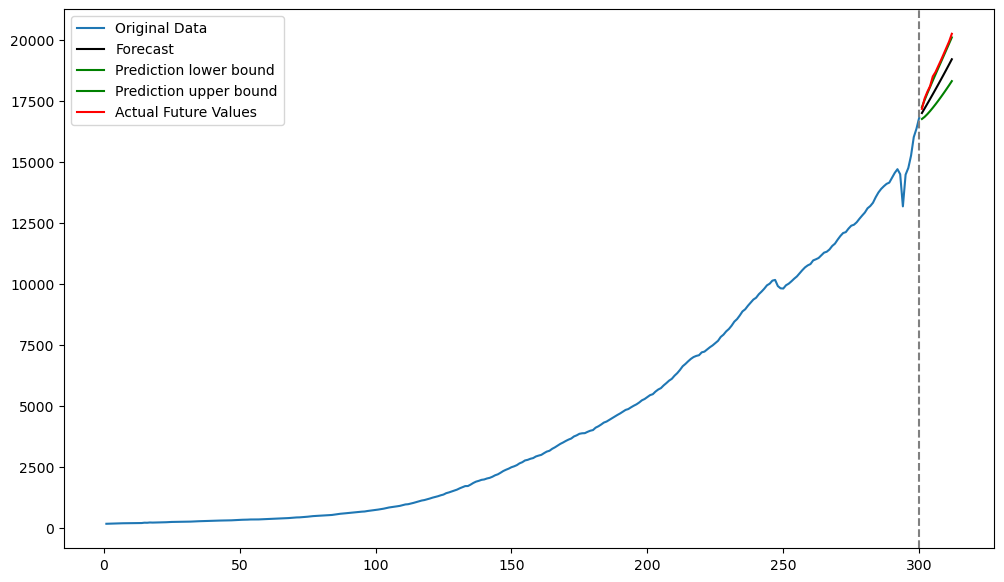

In [161]:
#Plotting predictions along with uncertainty:
plt.figure(figsize = (12, 7))
plt.plot(tme_train, y_train, label = 'Original Data')
plt.plot(tme_test, predvalues, label = 'Forecast', color = 'black')
plt.plot(tme_test, predlower, color = 'green', label = 'Prediction lower bound')
plt.plot(tme_test, predupper, color = 'green', label = 'Prediction upper bound')
plt.plot(tme_test, y_test, color = 'red', label = 'Actual Future Values')
plt.legend()
plt.axvline(x=n_train, color='gray', linestyle='--')
plt.show()

In this example, the predicted values are somewhat below the actual test values. The upper 95% interval values are almost coinciding with the actual test values. 

Instead of applying AR models, directly to the raw data, it is common practice to apply them to the logarithms. 

In [162]:
ylog_train = np.log(y_train)
ylog_test = np.log(y_test)

In [165]:
p = 1
armod_sm = AutoReg(ylog_train, lags = p).fit()
print(armod_sm.summary())

                            AutoReg Model Results                             
Dep. Variable:                   PCEC   No. Observations:                  300
Model:                     AutoReg(1)   Log Likelihood                 886.697
Method:               Conditional MLE   S.D. of innovations              0.012
Date:                Thu, 03 Apr 2025   AIC                          -1767.395
Time:                        15:56:11   BIC                          -1756.293
Sample:                             1   HQIC                         -1762.952
                                  300                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0255      0.004      6.726      0.000       0.018       0.033
PCEC.L1        0.9987      0.000   2031.123      0.000       0.998       1.000
                                    Roots           

Predictions are obtained as follows. 

In [166]:
fcast = armod_sm.get_prediction(start = n_train, end = n_train+k-1)
fcast_mean = fcast.predicted_mean #this gives the point predictions

Prediction uncertainty intervals are obtained as follows. 

In [167]:
fcast_se = fcast.se_mean
alpha = 0.05
z_alpha_half = stats.norm.ppf(1 - alpha/2)
predlower = fcast_mean - z_alpha_half * fcast_se
predupper = fcast_mean + z_alpha_half * fcast_se
fcast_int = fcast.conf_int()
print(np.column_stack([predlower, predupper, fcast_int]))

[[9.71848283 9.76736179 9.71848283 9.76736179]
 [9.72119381 9.79027425 9.72119381 9.79027425]
 [9.72625359 9.81080467 9.72625359 9.81080467]
 [9.73252367 9.83009157 9.73252367 9.83009157]
 [9.73956275 9.84857632 9.73956275 9.84857632]
 [9.74714436 9.86648543 9.74714436 9.86648543]
 [9.75513388 9.88395354 9.75513388 9.88395354]
 [9.76344355 9.90106847 9.76344355 9.90106847]
 [9.77201237 9.91789126 9.77201237 9.91789126]
 [9.78079591 9.93446638 9.78079591 9.93446638]
 [9.78976061 9.95082743 9.78976061 9.95082743]
 [9.79888039 9.96700055 9.79888039 9.96700055]]


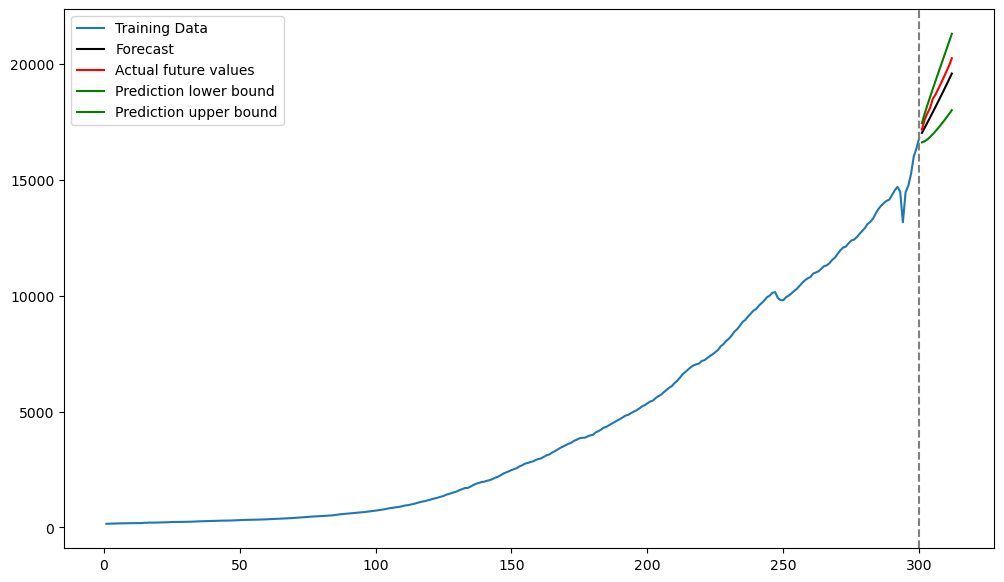

In [168]:
plt.figure(figsize = (12, 7))
plt.plot(tme_train, y_train, label = 'Training Data')
plt.plot(tme_test, np.exp(fcast_mean), label = 'Forecast', color = 'black') #Note the exponentiation
plt.plot(tme_test, y_test, color = 'red',  label = 'Actual future values')
plt.plot(tme_test, np.exp(predlower), color = 'green', label = 'Prediction lower bound')
plt.plot(tme_test, np.exp(predupper), color = 'green', label = 'Prediction upper bound')
plt.axvline(x=n_train, color='gray', linestyle='--')
plt.legend()
plt.show()

Now the predictions are more accurate. 

## How are the Prediction Uncertainties actually calculated?

We now calculate the prediction standard errors directly using the method described in class. The first step is to fit the AR(p) model and then to obtain estimates of $\phi_0, \dots, \phi_p$ as well as $\sigma$. There are two estimates of $\sigma$ (only difference being the denominators: $n-p$ vs $n-2p-1$).

In [169]:
yreg = ylog_train[p:] #these are the response values in the autoregression
Xmat = np.ones((n_train-p, 1)) #this will be the design matrix (X) in the autoregression
for j in range(1, p+1):
    col = ylog_train[p-j : n_train-j]
    Xmat = np.column_stack([Xmat, col])

armod = sm.OLS(yreg, Xmat).fit()
print(armod.params)
print(armod.summary())
sighat = np.sqrt(np.mean(armod.resid ** 2)) #note that this mean is taken over n-p observations
resdf = n_train - 2*p - 1
sigols = np.sqrt((np.sum(armod.resid ** 2))/resdf)
print(sighat, sigols)

const    0.025454
x1       0.998702
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                   PCEC   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.098e+06
Date:                Thu, 03 Apr 2025   Prob (F-statistic):               0.00
Time:                        16:42:25   Log-Likelihood:                 886.70
No. Observations:                 299   AIC:                            -1769.
Df Residuals:                     297   BIC:                            -1762.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c

The two estimates of $\sigma$ lead to two values for standard errors. 

In [170]:
covmat = (sighat ** 2) * np.linalg.inv(np.dot(Xmat.T, Xmat))
covmat_ols = (sigols ** 2) * np.linalg.inv(np.dot(Xmat.T, Xmat))
print(np.sqrt(np.diag(covmat)))
print(np.sqrt(np.diag(covmat_ols)))
print(armod_sm.bse)
print(armod.bse)

[0.00378458 0.0004917 ]
[0.0037973  0.00049335]
const      0.003785
PCEC.L1    0.000492
dtype: float64
const    0.003797
x1       0.000493
dtype: float64


The following code computes the prediction standard errors. It uses the matrix recursion method described in class. 

In [171]:
sigest = sighat
Gamhat = np.array([[sigest ** 2]])
vkp = np.array([[armod.params.iloc[1]]])

for i in range(1, k):
    covterm = Gamhat @ vkp 
    varterm = sigest**2 + (vkp.T @ (Gamhat @ vkp)) 
    Gamhat = np.block([
        [Gamhat,    covterm],
        [covterm.T, varterm ]
    ])
    if i < p:
        new_coef = armod.params.iloc[i+1]
        vkp = np.vstack([ [new_coef], vkp ])
    else:
        vkp = np.vstack([ [0], vkp ])
predsd = np.sqrt(np.diag(Gamhat))

#Check that this method produces the same standard errors as those computed by .se_mean:
print(np.column_stack([predsd, fcast_se]))

[[0.01246935 0.01246935]
 [0.01762289 0.01762289]
 [0.02156955 0.02156955]
 [0.02489023 0.02489023]
 [0.0278101  0.0278101 ]
 [0.03044471 0.03044471]
 [0.03286276 0.03286276]
 [0.03510904 0.03510904]
 [0.03721469 0.03721469]
 [0.03920237 0.03920237]
 [0.04108923 0.04108923]
 [0.04288859 0.04288859]]
